In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [15]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [16]:
df = pd.read_csv("../../../our_analyses/dataset_prepared.csv")

In [17]:
df['explicit'] = df['explicit'].apply(lambda x: 1 if x else 0)
df['genre'] = pd.factorize(df['genre'])[0]
y = np.array(df["genre"])
df = df.drop(['name', 'artists', 'album_name', 'genre'], axis=1)
X = df.values

In [18]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_minmax)

In [20]:
def get_linkage_matrix(model):
    # Create linkage matrix 
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

def plot_dendrogram(model, **kwargs):
    linkage_matrix = get_linkage_matrix(model)
    dendrogram(linkage_matrix, **kwargs)

### FInd the best number of cluster

In [21]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

silhouette_scores = []
for k in range(2, 11):  # Prova con un numero di cluster da 2 a 10
    model = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = model.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, labels)
    silhouette_scores.append(silhouette_avg)

# Trova il numero ottimale di cluster
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
print("Numero ottimale di cluster:", optimal_k)

# Ora puoi creare il modello con il numero ottimale di cluster
model = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')


Numero ottimale di cluster: 2


### Find the best distance threshold

In [22]:
# Range di valori per testare il distance_threshold
threshold_range = np.linspace(start=1, stop=90, num=20)

best_silhouette = -1
best_threshold = None

for threshold in threshold_range:
    model = AgglomerativeClustering(distance_threshold=threshold, n_clusters=None, metric="euclidean", linkage='ward')
    model = model.fit(X_pca)
    labels = model.labels_
    if len(set(labels)) > 1:  # Assicurati che ci siano almeno 2 cluster
        silhouette_avg = silhouette_score(X_pca, labels)
        print("Threshold:", threshold, "Silhouette:", silhouette_avg)
        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_threshold = threshold

print("Miglior distance_threshold:", best_threshold, "con silhouette di:", best_silhouette)


Threshold: 1.0 Silhouette: 0.17076313234743137
Threshold: 5.684210526315789 Silhouette: 0.18881989268694574
Threshold: 10.368421052631579 Silhouette: 0.22513801103950204
Threshold: 15.052631578947368 Silhouette: 0.2342366788063943
Threshold: 19.736842105263158 Silhouette: 0.27371365447205515
Threshold: 24.421052631578945 Silhouette: 0.2741416033373259
Threshold: 29.105263157894736 Silhouette: 0.27914913033448213
Threshold: 33.78947368421053 Silhouette: 0.26658359850808033
Threshold: 38.473684210526315 Silhouette: 0.2660229172599305
Threshold: 43.1578947368421 Silhouette: 0.27841987062530027
Threshold: 47.84210526315789 Silhouette: 0.27841987062530027
Threshold: 52.526315789473685 Silhouette: 0.33299245337629074
Threshold: 57.21052631578947 Silhouette: 0.33299245337629074
Threshold: 61.89473684210526 Silhouette: 0.33299245337629074
Threshold: 66.57894736842105 Silhouette: 0.33299245337629074
Threshold: 71.26315789473684 Silhouette: 0.33299245337629074
Threshold: 75.94736842105263 Silhou

### Try firstly with no specific values

Ward's Method (Euclidean): This method also reaches a silhouette score of approximately 0.33 at a higher threshold. The dendrogram shows compact and well-defined clusters, which is characteristic of Ward's method as it minimizes the total within-cluster variance.

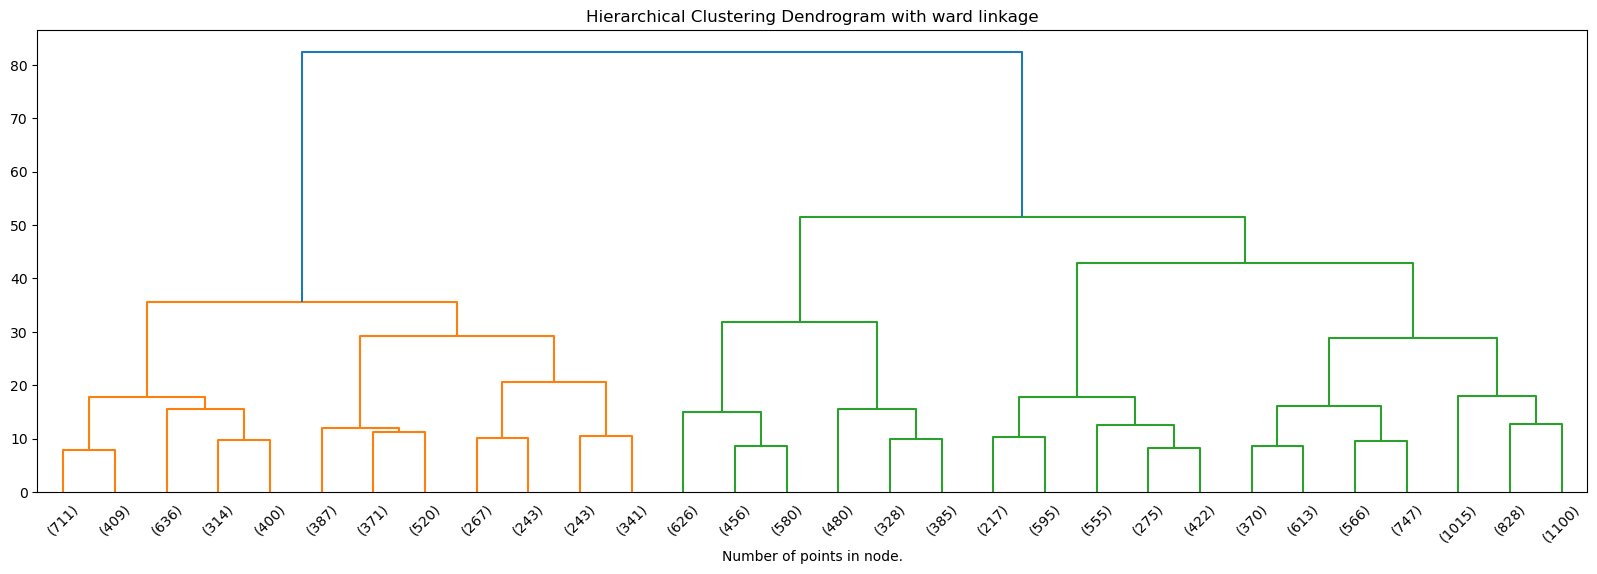

In [27]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, 
                                metric='euclidean', linkage='ward')
model = model.fit(X_pca)

plt.figure(figsize=(20, 6))
plt.title("Hierarchical Clustering Dendrogram with ward linkage")
plot_dendrogram(model, truncate_mode='lastp')
plt.xlabel("Number of points in node.")
plt.show()

### Calculate Silhoutte

In [24]:
Z = get_linkage_matrix(model)
labels = fcluster(Z, t=38.473684210526315, criterion='distance')

print('Silhouette', silhouette_score(X_pca, labels))

Silhouette 0.2660229172599305


### Choosing the number of clusters

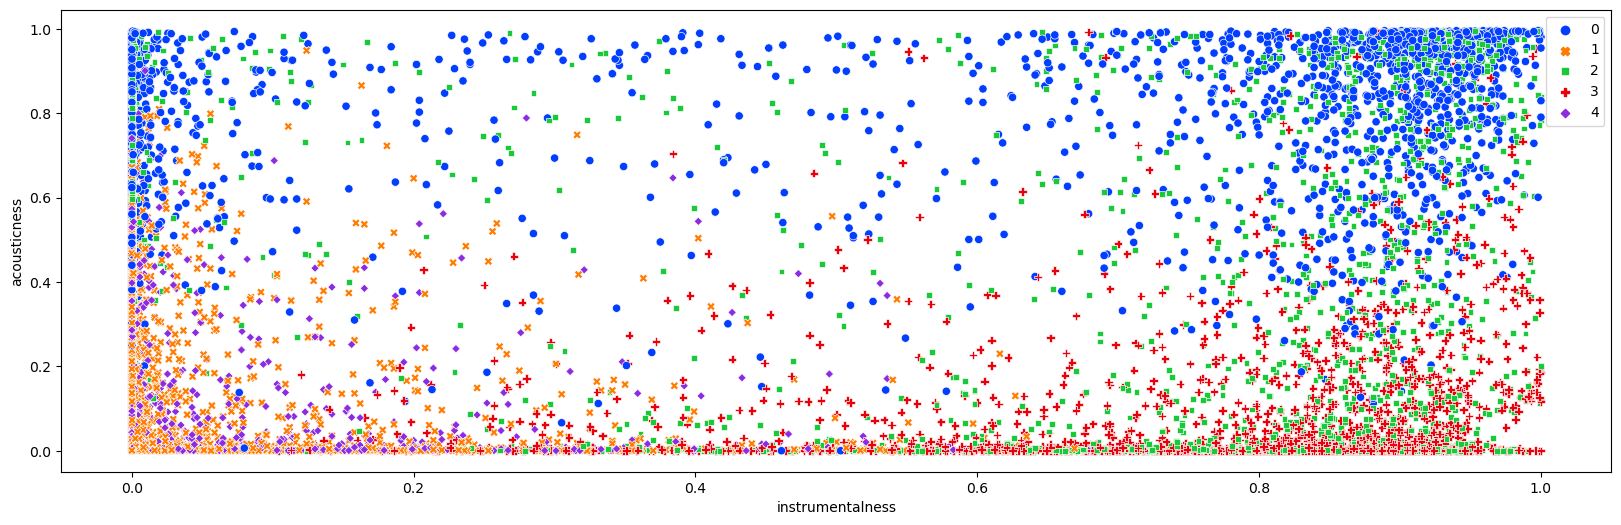

In [29]:
hier = AgglomerativeClustering(distance_threshold=33.78947368421053, n_clusters=None, metric="euclidean", linkage='ward')
hier.fit(X_pca)

plt.figure(figsize=(20, 6))

sns.scatterplot(data=df, 
                x="instrumentalness",
                y="acousticness", 
                hue=hier.labels_, 
                style=hier.labels_, 
                palette="bright")
plt.show()

### connectivity in Clustering Gerarchico
Nel contesto del clustering gerarchico, connectivity è una matrice che definisce la struttura dei dati o il modo in cui i punti dati sono connessi tra loro. Questa connettività può influenzare come i cluster vengono formati durante l'algoritmo di clustering.

kneighbors_graph: Questa funzione costruisce una matrice di connettività basata sui k vicini più prossimi di ciascun punto. In questo caso, n_neighbors=100 significa che per ogni punto dati, stai considerando i suoi 100 vicini più prossimi per definire la connettività.

include_self=False: Indica che il punto stesso non dovrebbe essere incluso nei suoi vicini più prossimi.

Utilizzare una matrice di connettività nel clustering gerarchico è utile per considerare solo certe relazioni tra i punti, ad esempio per imporre una struttura di vicinato o per lavorare con dati che hanno una struttura di rete o grafica intrinseca.

In [26]:
from sklearn.cluster import AgglomerativeClustering

# Esegui l'Hierarchical Clustering
model = AgglomerativeClustering(distance_threshold=38.473684210526315, n_clusters=None, metric="euclidean", linkage='ward')
model = model.fit(X_pca)

# Assegna le etichette dei cluster dal modello di Hierarchical Clustering
hierarchical_cluster_labels = model.labels_

# Crea una nuova colonna nel DataFrame per i cluster
df['cluster'] = hierarchical_cluster_labels

# Dato che 'genre' è stato rimosso da df e salvato in y, aggiungiamo 'genre' di nuovo a df
df['genre'] = y

# Calcolare la frequenza di ogni genere in ciascun cluster
cluster_genre_counts = df.groupby(['cluster', 'genre']).size().unstack(fill_value=0)

# Calcolare la dimensione di ogni cluster
cluster_sizes = df['cluster'].value_counts()

# Calcolare le proporzioni relative di ogni genere all'interno dei cluster
cluster_genre_proportions = cluster_genre_counts.div(cluster_sizes, axis=0)

# Determinare il cluster dominante per ogni genere basandosi sulle proporzioni
dominant_cluster_per_genre = cluster_genre_proportions.idxmax(axis=0)

print(dominant_cluster_per_genre)


genre
0     0
1     3
2     2
3     1
4     3
5     3
6     2
7     1
8     1
9     3
10    2
11    1
12    3
13    1
14    1
15    2
16    2
17    1
18    2
19    3
dtype: int64
